In [1]:
import geopandas as gpd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import shapely.wkt
import shapely.geometry
import pandas as pd
import shapely.geometry.multipolygon as sh

In [2]:
## First, I try to create a bouadary of THialand for acquiring data##
thailandmap = gpd.read_file('Data\\tha_admbnda_adm1_rtsd_20220121\\tha_admbnda_adm1_rtsd_20220121.shp')
thailandmap.crs = {'init': 'epsg:4326'}
min_lon = thailandmap.unary_union.bounds[0]
max_lon = thailandmap.unary_union.bounds[2]
max_lat = thailandmap.unary_union.bounds[1]
min_lat = thailandmap.unary_union.bounds[3]

d:\workstation\REPowerPlant_Siting\env\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\595078\AppData\Local\Temp\ipykernel_18996\346630003.py:4: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  min_lon = thailandmap.unary_union.bounds[0]
C:\Users\595078\AppData\Local\Temp\ipykernel_18996\346630003.py:5: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  max_lon = thailandmap.unary_union.bounds[2]
C:\Users\595078\AppData\Local\Temp\ipykernel_18996\346630003.py:6: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.


Data variables:
    SI_Solar   (lat, lon) float64 128MB ...
    SI_Wind    (lat, lon) float64 128MB ...
    ADM1_EN    (lat, lon) <U24 2GB ...
    A_BGEC     (lat, lon) float64 128MB ...
    A_Biomass  (lat, lon) float64 128MB ...
    A_BGWW     (lat, lon) float64 128MB ...
    A_MSW      (lat, lon) float64 128MB ...
    A_IEW      (lat, lon) float64 128MB ...
    AVA_Wind   (lat, lon) float32 64MB ...
    AVA_Solar  (lat, lon) float32 64MB ...


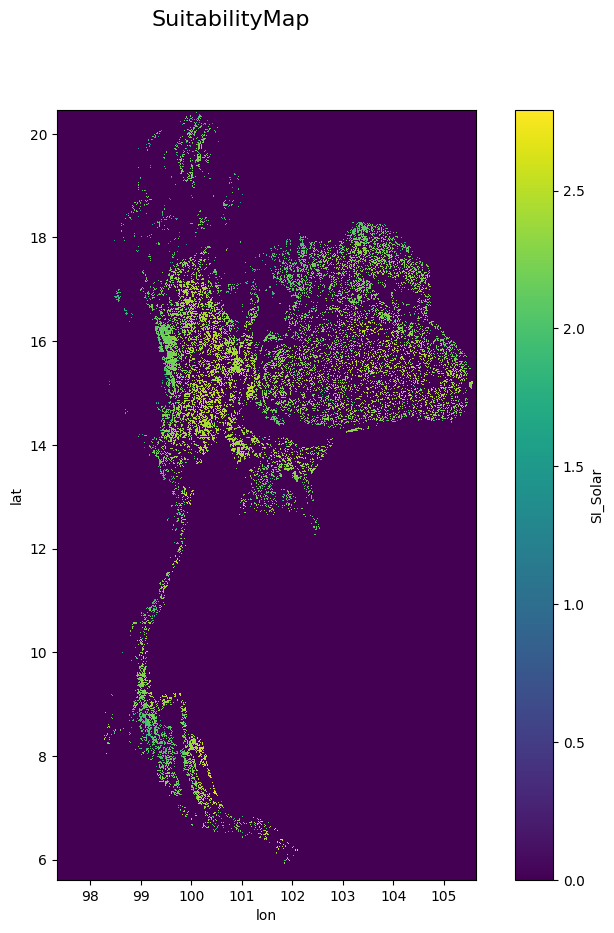

In [3]:
xr_landuse_suitability_index = xr.open_dataset('Output\\xr_final_SI.nc')
print(xr_landuse_suitability_index.data_vars)
fig, ax = plt.subplots(figsize=(10,10))
title = 'SuitabilityMap'
type = 'SI_Solar' 
fig.suptitle(str(title), fontsize=16)
thailandmap.plot(ax = ax, color='none', edgecolor = 'black', zorder = 0,alpha = 0.1)
xr_landuse_suitability_index[type].plot(ax = ax,zorder = 1)

d:\workstation\REPowerPlant_Siting\env\Lib\site-packages\matplotlib\axes\_axes.py:6973: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
d:\workstation\REPowerPlant_Siting\env\Lib\site-packages\matplotlib\axes\_axes.py:6974: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


(array([[0.00000e+00, 0.00000e+00, 0.00000e+00, ..., 0.00000e+00,
         0.00000e+00, 0.00000e+00],
        [0.00000e+00, 0.00000e+00, 0.00000e+00, ..., 0.00000e+00,
         0.00000e+00, 0.00000e+00],
        [0.00000e+00, 0.00000e+00, 0.00000e+00, ..., 0.00000e+00,
         0.00000e+00, 0.00000e+00],
        ...,
        [1.70000e+01, 2.17000e+02, 2.36500e+03, ..., 2.50602e+05,
         1.50630e+04, 1.53300e+03],
        [1.70000e+01, 2.17000e+02, 2.36500e+03, ..., 2.50602e+05,
         1.50630e+04, 1.53300e+03],
        [1.70000e+01, 2.17000e+02, 2.36500e+03, ..., 2.50602e+05,
         1.50630e+04, 1.53300e+03]]),
 array([1.17531848, 1.31014839, 1.44497831, 1.57980822, 1.71463813,
        1.84946805, 1.98429796, 2.11912787, 2.25395778, 2.3887877 ,
        2.52361761, 2.65844752, 2.79327744]),
 <a list of 2985 BarContainer objects>)

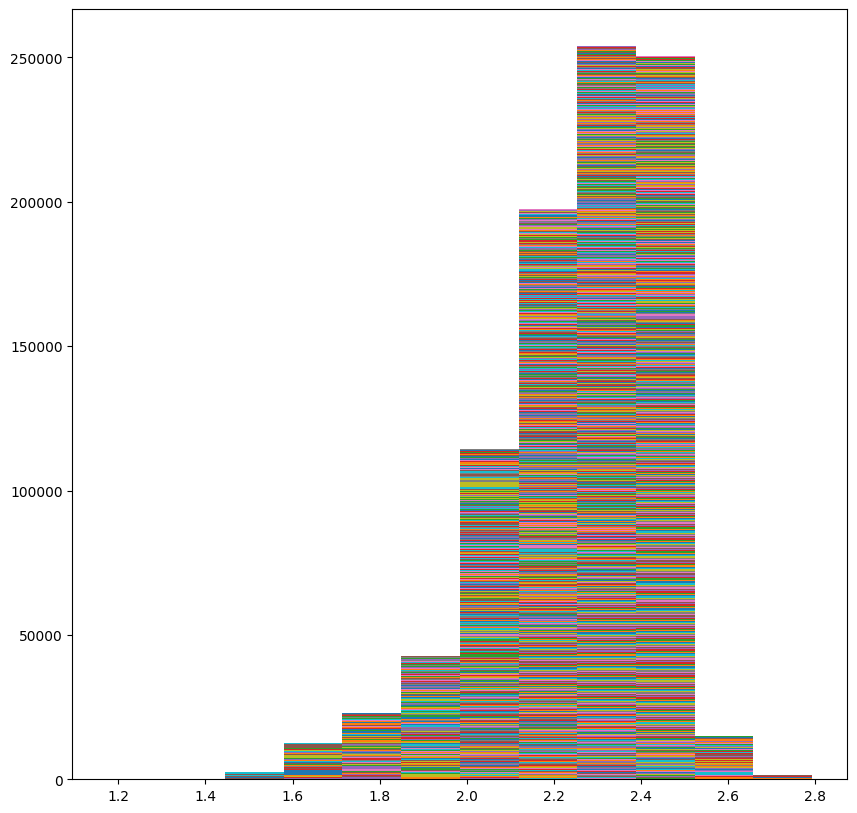

In [4]:
fig, ax = plt.subplots(figsize=(10,10))
plt.hist(xr_landuse_suitability_index[type].where(xr_landuse_suitability_index[type]>0),histtype ='barstacked',bins=12)

In [5]:
print(xr_landuse_suitability_index['SI_Solar'].where(xr_landuse_suitability_index['SI_Solar']==1).count() * 0.09)

<xarray.DataArray 'SI_Solar' ()> Size: 8B
array(0.)


In [10]:
province = "Nakhon Si Thammarat"
province_th = thailandmap.loc[thailandmap['ADM1_EN'] == province]
min_lon = province_th.unary_union.bounds[0]
max_lon = province_th.unary_union.bounds[2]
max_lat = province_th.unary_union.bounds[1]
min_lat = province_th.unary_union.bounds[3]

C:\Users\595078\AppData\Local\Temp\ipykernel_18996\4041111377.py:3: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  min_lon = province_th.unary_union.bounds[0]
C:\Users\595078\AppData\Local\Temp\ipykernel_18996\4041111377.py:4: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  max_lon = province_th.unary_union.bounds[2]
C:\Users\595078\AppData\Local\Temp\ipykernel_18996\4041111377.py:5: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  max_lat = province_th.unary_union.bounds[1]
C:\Users\595078\AppData\Local\Temp\ipykernel_18996\4041111377.py:6: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  min_lat = province_th.unary_union.bounds[3]


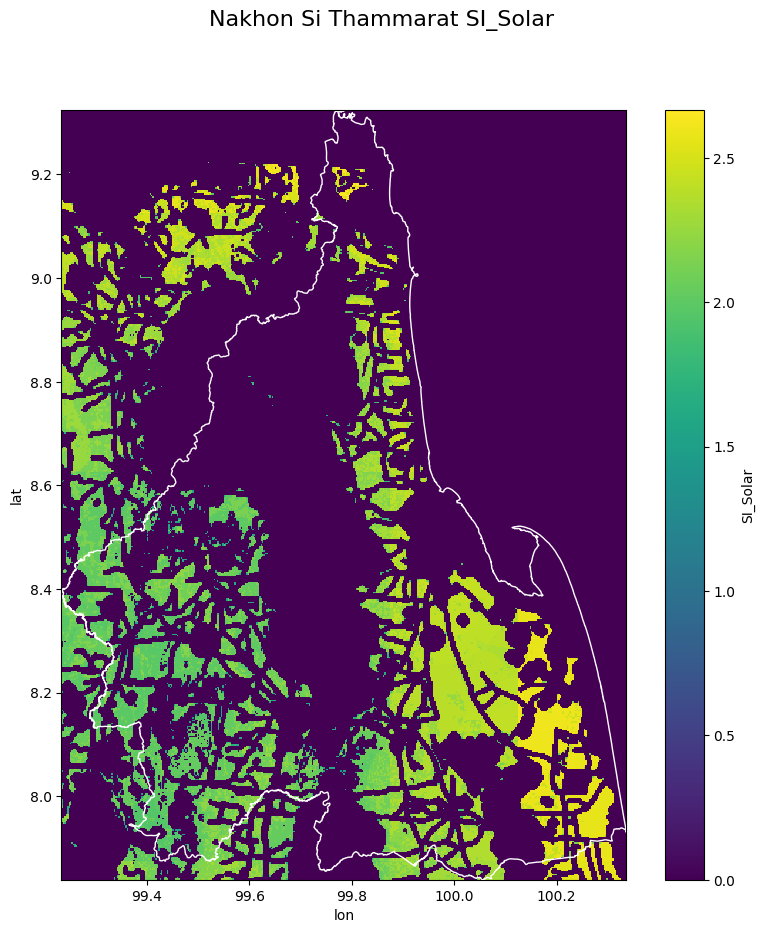

In [11]:
xr_landuse_suitability_index_area = xr_landuse_suitability_index.sel(lat=slice(max_lat,min_lat), lon=slice(min_lon,max_lon))
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle(province +' '+ str(type), fontsize=16)
province_th.plot(ax = ax, color='none', edgecolor = 'white', zorder = 1)
xr_landuse_suitability_index_area[type].plot(ax = ax,zorder = 0)